In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/Gohar-Sahab-Work/dataset.xlsx')
df.head()

,Continent,Country,Month,Year,Class,Category_id
0,Africa,Morocco,June,2020,Phishing,0
1,Africa,Middle East,September,2020,Malware,1
2,Africa,North Africa,September,2020,Malware,1
3,Africa,Africa,October,2020,Malware,1
4,Africa,Africa,December,2020,Phishing,0


In [17]:
df.tail()

,Continent,Country,Month,Year,Class,Category_id
391,United States,U.S,April,2021,Malware,1
392,United States,THE UNITED STATES,April,2021,Malware,1
393,United States,U.S,May,2021,DDoS,3
394,United States,US,May,2021,Phishing,0
395,United States,U.S,May,2021,Malware,1


In [18]:
df = df[pd.notnull(df['Country'])]

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 396 entries, 0 to 395
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Continent    396 non-null    object
 1   Country      396 non-null    object
 2   Month        396 non-null    object
 3   Year         396 non-null    int64 
 4   Class        396 non-null    object
 5   Category_id  396 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 21.7+ KB


In [20]:
col = ['Continent', 'Country']
df = df[col]  

In [21]:
df.columns

Index(['Continent', 'Country'], dtype='object')

In [22]:
df.columns = ['Continent', 'Country']

In [23]:
df['Category_id'] = df['Continent'].factorize()[0]
from io import StringIO
category_id_df = df[['Continent', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['Category_id', 'Continent']].values)

In [24]:
df.head()

,Continent,Country,Category_id
0,Africa,Morocco,0
1,Africa,Middle East,0
2,Africa,North Africa,0
3,Africa,Africa,0
4,Africa,Africa,0


In [25]:
df.tail()

,Continent,Country,Category_id
391,United States,U.S,6
392,United States,THE UNITED STATES,6
393,United States,U.S,6
394,United States,US,6
395,United States,U.S,6


In [26]:
df

,Continent,Country,Category_id
0,Africa,Morocco,0
1,Africa,Middle East,0
2,Africa,North Africa,0
3,Africa,Africa,0
4,Africa,Africa,0
...,...,...,...
391,United States,U.S,6
392,United States,THE UNITED STATES,6
393,United States,U.S,6
394,United States,US,6


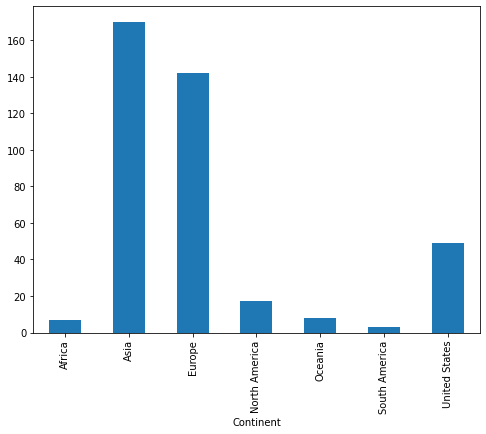

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Continent').Country.count().plot.bar(ylim=0)
plt.show()

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.Country).toarray()
labels = df.Category_id
features.shape                                                                 

(396, 32)

In [29]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Continent, Category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == Category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Continent))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'Africa':
  . Most correlated unigrams:
       . middle
       . north
  . Most correlated bigrams:
       . south asia
       . middle east
# 'Asia':
  . Most correlated unigrams:
       . china
       . india
  . Most correlated bigrams:
       . north korea
       . south asia
# 'Europe':
  . Most correlated unigrams:
       . germany
       . europe
  . Most correlated bigrams:
       . south asia
       . middle east
# 'North America':
  . Most correlated unigrams:
       . america
       . canada
  . Most correlated bigrams:
       . south asia
       . middle east
# 'Oceania':
  . Most correlated unigrams:
       . europe
       . australia
  . Most correlated bigrams:
       . south asia
       . middle east
# 'South America':
  . Most correlated unigrams:
       . india
       . europe
  . Most correlated bigrams:
       . south asia
       . middle east
# 'United States':
  . Most correlated unigrams:
       . europe
       . united
  . Most correlated bigrams:
       . sou

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['Country'], df['Continent'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [31]:
print(clf.predict(count_vect.transform(["Status updated for the country"])))

['Europe']


In [32]:
print(clf.predict(count_vect.transform(["Status updated reporting"])))

['Asia']


In [33]:
df[df['Country'] == "This country status"]

,Continent,Country,Category_id


In [34]:
df[df['Country'] == "Status"]

,Continent,Country,Category_id


In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


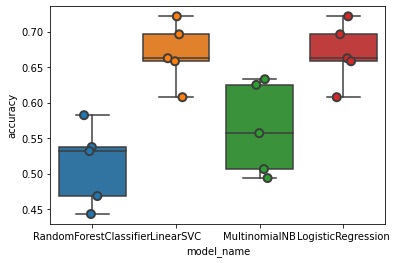

In [36]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [37]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.669209
LogisticRegression        0.669209
MultinomialNB             0.562975
RandomForestClassifier    0.512563
Name: accuracy, dtype: float64

In [77]:
from sklearn.model_selection import train_test_split

model = LinearSVC()
#model = LogisticRegression()
#model = MultinomialNB()
#model = RandomForestClassifier()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

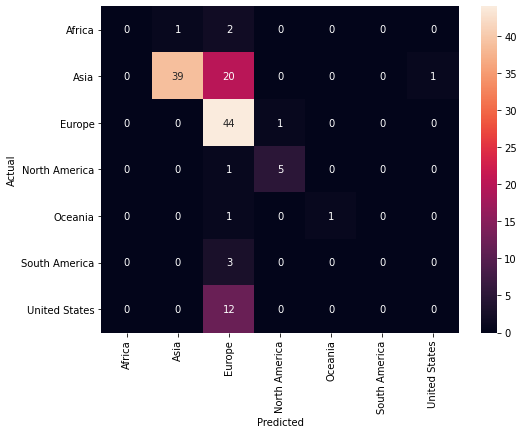

In [78]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Continent.values, yticklabels=category_id_df.Continent.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [66]:
from IPython.display import display

for predicted in category_id_df.Category_id:
  for actual in category_id_df.Category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 6:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Continent', 'Country']])
      print('')

'Asia' predicted as 'Europe' : 20 examples.


,Continent,Country
76,Asia,Kazakhstan
106,Asia,Nepal
132,Asia,Israel
150,Asia,Vietnam
113,Asia,Arabian Gulf
135,Asia,Lebanon
54,Asia,Uyghur
164,Asia,Vietnam
45,Asia,Singapore
15,Asia,Malaysia



'United States' predicted as 'Europe' : 12 examples.


,Continent,Country
356,United States,U.S
395,United States,U.S
376,United States,U.S
355,United States,U.S
370,United States,U.S
360,United States,U.S
367,United States,U.S
369,United States,U.S
350,United States,U.S
390,United States,U.S


In [67]:
model.fit(features, labels)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [68]:
from sklearn.feature_selection import chi2

N = 2
for Continent, Category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[Category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Continent))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'Africa':
  . Top unigrams:
       . north
       . middle
  . Top bigrams:
       . middle east
       . south asia
# 'Asia':
  . Top unigrams:
       . india
       . china
  . Top bigrams:
       . north korea
       . saudi arabia
# 'Europe':
  . Top unigrams:
       . europe
       . germany
  . Top bigrams:
       . south asia
       . southeast asia
# 'North America':
  . Top unigrams:
       . canada
       . america
  . Top bigrams:
       . southeast asia
       . south asia
# 'Oceania':
  . Top unigrams:
       . australia
       . southeast
  . Top bigrams:
       . south asia
       . north korea
# 'South America':
  . Top unigrams:
       . southeast
       . arabia
  . Top bigrams:
       . south asia
       . north korea
# 'United States':
  . Top unigrams:
       . united
       . america
  . Top bigrams:
       . north korea
       . south asia


In [69]:
texts = ["I want to check the country or continent which is more effected",
         "It is difficutl to know about the attacker",
         "Which country more effectd",
         "Let's experiment more",
         "Check the as whole status"]
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"I want to check the country or continent which is more effected"
  - Predicted as: 'Europe'

"It is difficutl to know about the attacker"
  - Predicted as: 'Europe'

"Which country more effectd"
  - Predicted as: 'Europe'

"Let's experiment more"
  - Predicted as: 'Europe'

"Check the as whole status"
  - Predicted as: 'Europe'



In [70]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['Continent'].unique()))

               precision    recall  f1-score   support

       Africa       0.00      0.00      0.00         3
         Asia       0.97      0.65      0.78        60
       Europe       0.53      0.98      0.69        45
North America       0.83      0.83      0.83         6
      Oceania       1.00      0.50      0.67         2
South America       0.00      0.00      0.00         3
United States       0.00      0.00      0.00        12

     accuracy                           0.68       131
    macro avg       0.48      0.42      0.42       131
 weighted avg       0.68      0.68      0.64       131



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
